In [1]:
import matplotlib.pyplot as plt
import matplotlib.image
import rasterio
import rasterio.plot
import rasterio.merge
import rasterio.mask
import geopandas as gpd
import cartopy.crs as ccrs
import numpy as np
import warnings
import time
import pandas as pd

In [2]:
import functions

### Start  again by loading in all the gauge data
Note: this is the output from the last cell in the "Slope steepness from DEM" notebook <br>
Make sure to remove the 3 unfound gauges (filter < 99)

In [3]:
gauges = gpd.read_file("Gauge Data/Gauges-with-raster-id.shp",crs=4326)

In [4]:
gauges.query("raster_id < 99", inplace=True)
gauges.reset_index(inplace=True)
gauges.reset_index(inplace=True)
gauges.drop(columns="index",inplace=True)
gauges

,level_0,src_id,station_na,station_fi,historic_c,station_la,station_lo,station_el,first_year,last_year,raster_id,geometry
0,0,00003,FAIR ISLE,fair-isle,shetland,59.526,-1.630,57,1974,2020,4,POINT (-1.63000 59.52600)
1,1,00023,KIRKWALL,kirkwall,orkney,58.953,-2.901,26,1957,2020,4,POINT (-2.90100 58.95300)
2,2,00032,WICK AIRPORT,wick-airport,caithness,58.454,-3.090,36,1930,2020,4,POINT (-3.09000 58.45400)
3,3,00040,CASSLEY,cassley,sutherland,58.168,-4.727,99,1999,2020,4,POINT (-4.72700 58.16800)
4,4,00044,ALTNAHARRA NO 2,altnaharra-no-2,sutherland,58.288,-4.442,81,1993,2020,4,POINT (-4.44200 58.28800)
...,...,...,...,...,...,...,...,...,...,...,...,...
360,360,24218,HARTPURY COLLEGE,hartpury-college,gloucestershire,51.904,-2.312,41,1998,2020,1,POINT (-2.31200 51.90400)
361,361,24219,MANNINGTON HALL,mannington-hall,norfolk,52.844,1.179,30,1999,2020,0,POINT (1.17900 52.84400)
362,362,57118,BUTE: ROTHESAY NO2,bute-rothesay-no2,buteshire,55.825,-5.056,36,2013,2020,5,POINT (-5.05600 55.82500)
363,363,57233,MARGAM NO 2,margam-no-2,glamorganshire,51.555,-3.721,40,2013,2020,1,POINT (-3.72100 51.55500)


The cropped data is indexed by the filenames first so still need those

In [5]:
filenames = []
with open("Cropped Data/filenames.txt") as fin:
    for line in fin:
        filenames.append(line.strip())
# filenames

In [6]:
UK = filenames[68:69] + filenames[80:83] + filenames[95:97]
print(UK)

['n50e000_dem', 'n50w005_dem', 'n50w010_dem', 'n50w015_dem', 'n55w005_dem', 'n55w010_dem']


#### Up until now  main focus has been on a slope of given length
now, first consider a close by slope e.g. 1 - 5px and then look how long this continues for. 

In [7]:
number_px = 5
instance = functions.Raster_Location_OnSlope(gauges, UK, number_px)

#### This is a given array

In [8]:
print(f'Gauge height: {instance.get_array_given_orientation(0, "ns")[0][30]}, array:')
instance.get_array_given_orientation(0, "ns")[0]

Gauge height: 57, array:


array([-32768,    126,    139,    154,    176,    191,    190,    172,
          156,    151,    143,    134,    124,    120,    112,    101,
           90,     78,     75,     73,     70,     66,     62,     68,
           65,     58,     59,     61,     56,     56,     57,     57,
           53,     49,     41,     35,     44,     49,     38,     25,
           17,     35,     43,     22,      4, -32768, -32768, -32768,
       -32768, -32768, -32768, -32768, -32768, -32768, -32768, -32768,
       -32768, -32768, -32768, -32768, -32768], dtype=int16)

#### ant this is its steepness
here 'n_px=5' is used

In [9]:
instance.slope_steepness(1, "ns")

-10.934845977353204

#### we can then look just outside the previous range made used to caculate the steepness
Each on both sides taking the next segment of size equal to the stepsize

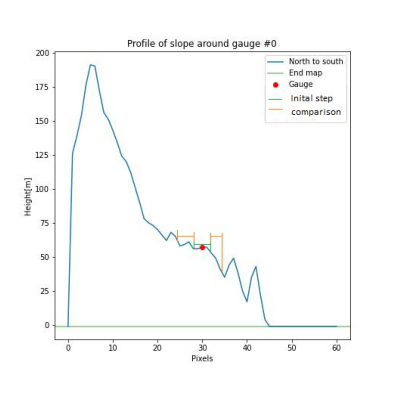

In [10]:
plt.figure(figsize=(7,7))
plt.imshow(matplotlib.image.imread("Figures/Profile of slope around gauge n0ns - showing steps.jpg"))
plt.axis("off");


#### consider this case:

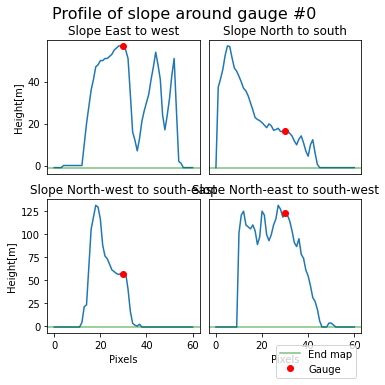

In [11]:
functions.plotting(gauges, UK, 5).plot_gauge(0, "all")

#### a function was written comparing the left and right slope, returning what it is
Again the amount of pixels matters, here we itterate over the availible 30 pixels<br>
Notice how above 15, it often starts to return flat: very little difference in the slope and left == right. <br>
if you do this for different stations we see a similar effect that higher pixel count causes this.<br>
Reason is we have 30 px, and we aready look 15, the other 15 aren't returning differing information <br>
So either increase size or stick to <15. <br>
5px seems to be a fair representation when comparing it to the plots

starting..... 2
0 ['Flat', 'Flat', 'Flat', 'Flat']
2.064122365384827 0.0
1 ['Flat', 'Slope', 'Slope', None]
0.0 -4.128244730769654
2 [None, 'Slope', 'Ridge', 'Ridge']
3 ['Slope', 'Slope', 'Slope', 'Ridge']
4 ['Ridge', 'Slope', 'Slope', 'Slope']
5 ['Ridge', 'Ridge', 'Slope', 'Ridge']
6 ['Ridge', 'Ridge', 'Ridge', 'Ridge']
7 ['Ridge', 'Ridge', 'Slope', 'Ridge']
8 ['Ridge', 'Ridge', 'Slope', 'Ridge']
9 ['Ridge', 'Ridge', 'Slope', 'Slope']
10 ['Ridge', 'Ridge', 'Slope', 'Slope']


C:\Users\david\Documents\@@ Python\Jaar 4\Q3\Are-rain-gauges-in-the-right-place\Location on slope from DEM\functions.py:115: RuntimeWarning: overflow encountered in short_scalars
  rise = item - array[index+1]


11 ['Ridge', 'Ridge', 'Valley', 'Valley']
12 ['Ridge', 'Slope', 'Valley', 'Valley']
13 ['Ridge', 'Slope', 'Valley', 'Valley']
14 ['Ridge', 'Slope', 'Slope', 'Valley']
15 ['Slope', 'Slope', 'Slope', 'Valley']
16 ['Slope', 'Valley', 'Flat', 'Valley']
17 ['Slope', 'Valley', 'Flat', 'Valley']
18 ['Slope', 'Valley', 'Flat', 'Valley']
19 ['Valley', 'Valley', 'Flat', 'Valley']
20 ['Valley', 'Valley', 'Flat', 'Valley']
21 ['Valley', 'Valley', 'Flat', 'Valley']
22 ['Valley', 'Valley', 'Flat', 'Flat']
23 ['Valley', 'Slope', 'Flat', 'Flat']
24 ['Valley', 'Slope', 'Flat', 'Flat']
25 ['Valley', 'Slope', 'Flat', 'Flat']
26 ['Valley', 'Slope', 'Flat', 'Flat']
27 ['Valley', 'Slope', 'Flat', 'Flat']
28 ['Valley', 'Slope', 'Flat', 'Flat']
29 ['Valley', 'Slope', 'Flat', 'Flat']


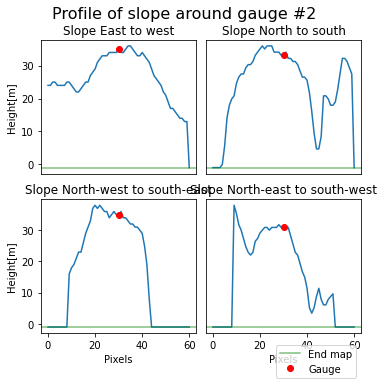

In [12]:
for j in [2]:
    print("starting.....",j)
    functions.plotting(gauges, UK, 5).plot_gauge(j, "all")
    for i in range(30):
        out = functions.Raster_Location_OnSlope(gauges, UK, i).get_location_on_slope(j)
        print(i,out)

#### This process can then be done for the whole dataframe:
(print statements are where one side is still none. from the data we can see these are generally flat anyway,but the delta is so close to zero python makes it zero, to be fixed later)

In [13]:
 gauges["slope_location"] = functions.Raster_Location_OnSlope(gauges, UK, 5).run_location_on_slope()

0.0 -1.831762712751481
-0.8545967730822646 0.0
-0.9451590673130904 0.0
-0.4574267356459514 0.0
0.4574267356459514 0.0
0.0 -1.808787641442025
0.0 -0.45219691036050624


In [14]:
gauges.head(2)

,level_0,src_id,station_na,station_fi,historic_c,station_la,station_lo,station_el,first_year,last_year,raster_id,geometry,slope_location
0,0,00003,FAIR ISLE,fair-isle,shetland,59.526,-1.630,57,1974,2020,4,POINT (-1.63000 59.52600),"[Slope, Slope, Valley, Slope]"
1,1,00023,KIRKWALL,kirkwall,orkney,58.953,-2.901,26,1957,2020,4,POINT (-2.90100 58.95300),"[Ridge, Slope, Slope, Slope]"


#### load in data from the other notebook 


In [15]:
DEM = pd.read_csv("Slopes computed from DEM.csv",index_col=0)

In [16]:
DEM_sparse = DEM.drop(columns=['level_0', 'station_na', 'station_fi',
       'historic_c', 'station_la', 'station_lo', 'station_el', 'first_year',
       'last_year', 'raster_id', 'geometry'])
DEM_sparse.head(1)

,src_id,computed_height,difference_height,slope_steepness,abs_slope_steepness,dir_slope_steepness
0,3,57,0,14.2,14.2,nw-se


Ensure data types are same

In [17]:
gauges.src_id  = gauges.src_id.astype(int)
gauges.head(1)

,level_0,src_id,station_na,station_fi,historic_c,station_la,station_lo,station_el,first_year,last_year,raster_id,geometry,slope_location
0,0,3,FAIR ISLE,fair-isle,shetland,59.526,-1.63,57,1974,2020,4,POINT (-1.63000 59.52600),"[Slope, Slope, Valley, Slope]"


In [18]:
gauges = gauges.merge(DEM_sparse,on="src_id")
gauges

,level_0,src_id,station_na,station_fi,historic_c,station_la,station_lo,station_el,first_year,last_year,raster_id,geometry,slope_location,computed_height,difference_height,slope_steepness,abs_slope_steepness,dir_slope_steepness
0,0,3,FAIR ISLE,fair-isle,shetland,59.526,-1.630,57,1974,2020,4,POINT (-1.63000 59.52600),"[Slope, Slope, Valley, Slope]",57,0,14.20,14.20,nw-se
1,1,23,KIRKWALL,kirkwall,orkney,58.953,-2.901,26,1957,2020,4,POINT (-2.90100 58.95300),"[Ridge, Slope, Slope, Slope]",31,5,-11.63,11.63,nw-se
2,2,32,WICK AIRPORT,wick-airport,caithness,58.454,-3.090,36,1930,2020,4,POINT (-3.09000 58.45400),"[Ridge, Ridge, Slope, Ridge]",35,1,2.06,2.06,ne-sw
3,3,40,CASSLEY,cassley,sutherland,58.168,-4.727,99,1999,2020,4,POINT (-4.72700 58.16800),"[Slope, Slope, Slope, Valley]",106,7,-16.15,16.15,ne-sw
4,4,44,ALTNAHARRA NO 2,altnaharra-no-2,sutherland,58.288,-4.442,81,1993,2020,4,POINT (-4.44200 58.28800),"[Valley, Valley, Valley, Valley]",78,3,3.42,3.42,ns
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,360,24218,HARTPURY COLLEGE,hartpury-college,gloucestershire,51.904,-2.312,41,1998,2020,1,POINT (-2.31200 51.90400),"[Ridge, Slope, Slope, Slope]",31,10,-2.14,2.14,ew
361,361,24219,MANNINGTON HALL,mannington-hall,norfolk,52.844,1.179,30,1999,2020,0,POINT (1.17900 52.84400),"[Valley, Slope, Slope, Valley]",35,5,-3.58,3.58,nw-se
362,362,57118,BUTE: ROTHESAY NO2,bute-rothesay-no2,buteshire,55.825,-5.056,36,2013,2020,5,POINT (-5.05600 55.82500),"[Slope, Slope, Slope, Slope]",32,4,-10.47,10.47,nw-se
363,363,57233,MARGAM NO 2,margam-no-2,glamorganshire,51.555,-3.721,40,2013,2020,1,POINT (-3.72100 51.55500),"[Slope, Slope, Ridge, Slope]",38,2,6.75,6.75,ne-sw


We can then manipulate the data from the dataframe, here we take the slope direction from 

In [19]:
gauges["location_steepest_slope"] = functions.Raster_Location_OnSlope(gauges, UK, 5).run_location_on_slope_direction()

In [25]:
gauges.to_csv("Gauge Data\computed slope location.csv")

In [20]:
print(f'Gauge height: {instance.get_array_given_orientation(0, "ns")[0][30]}, array:')
instance.get_array_given_orientation(0, "ns")[0]

Gauge height: 57, array:


array([-32768,    126,    139,    154,    176,    191,    190,    172,
          156,    151,    143,    134,    124,    120,    112,    101,
           90,     78,     75,     73,     70,     66,     62,     68,
           65,     58,     59,     61,     56,     56,     57,     57,
           53,     49,     41,     35,     44,     49,     38,     25,
           17,     35,     43,     22,      4, -32768, -32768, -32768,
       -32768, -32768, -32768, -32768, -32768, -32768, -32768, -32768,
       -32768, -32768, -32768, -32768, -32768], dtype=int16)

#### looking at when slope steepness changes:
i'll get back to this, the cells are roling again, which is what we want

In [21]:
instance.get_array_step(0,"ns",1, "right", True),\
instance.get_array_step(0,"ns",2, "right", True),\
instance.get_array_step(0,"ns",3, "right", True),\
instance.get_array_step(0,"ns",1, "left", True),\
instance.get_array_step(0,"ns",2, "left", True),\
instance.get_array_step(0,"ns",3, "left", True)

(array([35, 44], dtype=int16),
 array([44, 49], dtype=int16),
 array([49, 38], dtype=int16),
 array([65, 58], dtype=int16),
 array([68, 65], dtype=int16),
 array([62, 68], dtype=int16))

In [22]:
instance.change_slope_steepness(1, "ew", 1, 5)

initial.....-1.1632814869524686
left=-2.093906676514443, #1
left=-2.093906676514443, #2
left=0.0, #3
left=-2.093906676514443, #4
left=-2.093906676514443, #5
left=-2.093906676514443, #6
left=-2.093906676514443, #7
left=-2.093906676514443, #8
left=0.0, #9
left=0.0, #10
left=0.0, #11
left=2.093906676514443, #12
left=2.093906676514443, #13
left=2.093906676514443, #14
left=0.0, #15
30
right=0.0, #1
30
right=0.0, #2
30
right=0.0, #3
30
right=2.093906676514443, #4
30
right=2.093906676514443, #5
30
right=2.093906676514443, #6
30
right=0.0, #7
30
right=-2.093906676514443, #8
30
right=-2.093906676514443, #9
30
right=-2.093906676514443, #10
30
right=-2.093906676514443, #11
30
right=-4.187813353028886, #12
30
right=-2.093906676514443, #13
30
right=-2.093906676514443, #14
30
right=-2.093906676514443, #15
30
right=-4.187813353028886, #16
30
right=0.0, #17
30
right=2.093906676514443, #18
30
right=2.093906676514443, #19


(15, 19)